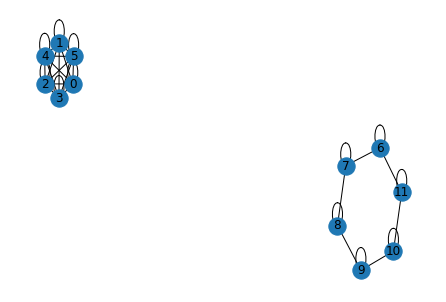

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-colorblind')
import scipy.stats as sps
import networkx as nx
import time
from Dist_UCB1_Small_Graphs import Dist_UCB1
import os
from multiprocess import Pool

n_runs = 100
T = 10000
G1 = nx.complete_graph(6)
G2 = nx.cycle_graph([6,7,8,9,10,11])
G = nx.compose(G1,G2)
N = G.number_of_nodes()

nodes = list(G.nodes)
for i in nodes:
    G.add_edge(i,i)
nx.draw(G, with_labels=True)

rwd_means = [.2, .3, .4, .5, .6]
betas = [1, 1, 1, 0.01, 0.01, 0.01, 1, 1, 1, 0.01, 0.01, 0.01]
seeds = [i for i in range(n_runs)]

In [13]:
def worker(job_runs, seeds, betas, T, N, G):
    regrets_dist_ucb1 = np.zeros((len(job_runs), N, T))
    for run in job_runs:
        start_run_t = time.time()
        
        sd = 0.1
        kl_distributions = [sps.truncnorm(a=(0-rwd_means[i])/sd, b=(1-rwd_means[i])/sd, loc=rwd_means[i], scale=sd) for i in range(len(rwd_means))]
        for i in range(len(rwd_means)):
            kl_distributions[i].random_state = np.random.RandomState(seed=seeds[run])
        distributions = [[sps.truncnorm(a=(0-rwd_means[i])/sd, b=(1-rwd_means[i])/sd, loc=rwd_means[i], scale=sd) for i in range(len(rwd_means))] for n in range(N)]
        for n in range(N):
            for i in range(len(rwd_means)):
                distributions[n][i].random_state = np.random.RandomState(seed=seeds[run])
        
        #sigmas = [1, 1 0.01, 0.01]
        distucb1 = Dist_UCB1(T, distributions, G, beta=betas)
        distucb1.run()
        regrets_dist_ucb1[run-job_runs[0], :, :] = distucb1.regrets
        
        end_run_t = time.time()
        print(f'finished run {run} in {end_run_t - start_run_t}sec')
    return regrets_dist_ucb1

In [14]:
regrets_dist_ucb1 = np.zeros((n_runs, N, T))
init_time = time.time()
cpus = os.cpu_count()
init_time = time.time()

pool = Pool() # no need to pass in cpus, does os.cpu_count() by default
jobs = list(range(n_runs))
job_size = n_runs // cpus
job_chunks = [(jobs[i:i + job_size], seeds, betas, T, N, G) for i in range(0, len(jobs), job_size)]
results = pool.starmap(worker, job_chunks)
pool.close()
pool.join()
regrets_dist_ucb1_unconcat = [result for result in results]
np.concatenate(regrets_dist_ucb1_unconcat, out=regrets_dist_ucb1)

end_run_t = time.time()

time_axis = list(range(T))
mean_regrets_over_all_runs_dist_ucb1 = np.mean(regrets_dist_ucb1, axis=0)
std_regrets_over_all_runs_dist_ucb1 = np.std(regrets_dist_ucb1, axis=0)
print(f'Total run time = {end_run_t - init_time}sec')

/home/mulle/vip-mab/code/KL_UCB/Dist_UCB1_Small_Graphs.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_UCB1_Small_Graphs.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_UCB1_Small_Graphs.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_UCB1_Small_Graphs.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_UCB1_Small_Graphs.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home

finished run 56 in 55.51314616203308sec
finished run 80 in 56.3068368434906secfinished run 72 in 56.30896997451782sec

finished run 8 in 56.449934005737305sec
finished run 40 in 57.06077456474304sec
finished run 0 in 57.19822406768799sec
finished run 24 in 57.25321841239929sec
finished run 32 in 57.343918323516846sec
finished run 88 in 57.55233359336853sec
finished run 16 in 57.919506788253784sec
finished run 64 in 58.49689865112305sec
finished run 48 in 58.83419132232666sec
finished run 57 in 57.8048357963562sec
finished run 1 in 57.08149027824402sec
finished run 33 in 57.71737027168274sec
finished run 17 in 57.79149317741394sec
finished run 41 in 58.77355337142944sec
finished run 49 in 57.37777328491211sec
finished run 81 in 60.58683657646179sec
finished run 73 in 60.65469813346863sec
finished run 25 in 59.719289779663086sec
finished run 65 in 58.847251653671265sec
finished run 9 in 61.31150484085083sec
finished run 89 in 60.66234087944031sec
finished run 58 in 58.955580949783325sec


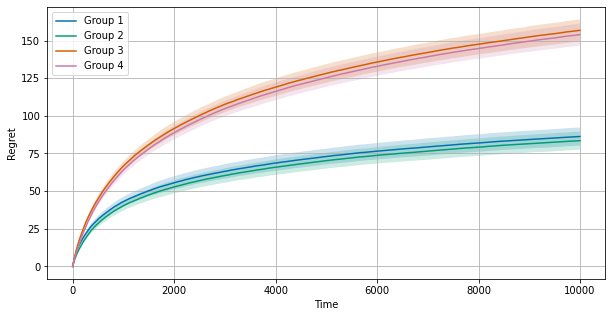

In [15]:
plt.figure(figsize=(10,5))
#plt.subplot(122)
neighbors = [1, 2, 2, 1]
#for sig in range(len(sigmas)):
#    plt.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[sig], )#label=r"$\varsigma=$" + str(sigmas[sig]) + ", " + r"$|\scr N_i|=$" + str(neighbors[sig]))
#    plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[sig]-std_regrets_over_all_runs_dist_kl_ucb[sig], mean_regrets_over_all_runs_dist_kl_ucb[sig]+std_regrets_over_all_runs_dist_kl_ucb[sig],alpha=.2)
#plt.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[0], label="Agent 1")
#plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[0]-std_regrets_over_all_runs_dist_ucb1[0], mean_regrets_over_all_runs_dist_ucb1[0]+std_regrets_over_all_runs_dist_ucb1[0],alpha=.2)
#plt.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[1], label="Agent 2")
#plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[1]-std_regrets_over_all_runs_dist_ucb1[1], mean_regrets_over_all_runs_dist_ucb1[1]+std_regrets_over_all_runs_dist_ucb1[1],alpha=.2)
#plt.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[2], label="Agent 3")
#plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[2]-std_regrets_over_all_runs_dist_ucb1[2], mean_regrets_over_all_runs_dist_ucb1[2]+std_regrets_over_all_runs_dist_ucb1[2],alpha=.2)
#plt.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[3], label="Agent 4")
#plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[3]-std_regrets_over_all_runs_dist_ucb1[3], mean_regrets_over_all_runs_dist_ucb1[3]+std_regrets_over_all_runs_dist_ucb1[3],alpha=.2)
avg_3_1_regret = np.mean(mean_regrets_over_all_runs_dist_ucb1[0:3], axis=0)
avg_3_001_regret = np.mean(mean_regrets_over_all_runs_dist_ucb1[3:6], axis=0)
avg_6_1_regret = np.mean(mean_regrets_over_all_runs_dist_ucb1[6:9], axis=0)
avg_6_001_regret = np.mean(mean_regrets_over_all_runs_dist_ucb1[9:12], axis=0)
std_3_1_regret = np.mean(std_regrets_over_all_runs_dist_ucb1[0:3], axis=0)
std_3_001_regret = np.mean(std_regrets_over_all_runs_dist_ucb1[3:6], axis=0)
std_6_1_regret = np.mean(std_regrets_over_all_runs_dist_ucb1[6:9], axis=0)
std_6_001_regret = np.mean(std_regrets_over_all_runs_dist_ucb1[9:12], axis=0)

plt.plot(time_axis, avg_3_1_regret, label="Group 1")
plt.fill_between(time_axis, avg_3_1_regret-std_3_1_regret, avg_3_1_regret+std_3_1_regret,alpha=.2)
plt.plot(time_axis, avg_3_001_regret, label="Group 2")
plt.fill_between(time_axis, avg_3_001_regret-std_3_001_regret, avg_3_001_regret+std_3_001_regret,alpha=.2)
plt.plot(time_axis, avg_6_1_regret, label="Group 3")
plt.fill_between(time_axis, avg_6_1_regret-std_6_1_regret, avg_6_1_regret+std_6_1_regret,alpha=.2)
plt.plot(time_axis, avg_6_001_regret, label="Group 4")
plt.fill_between(time_axis, avg_6_001_regret-std_6_001_regret, avg_6_001_regret+std_6_001_regret,alpha=.2)
plt.xlabel("Time")
plt.ylabel("Regret")
#plt.ylim([80,180])
plt.legend()
plt.grid()
#plt.subplot(121)
#nx.draw(G, with_labels=True)
#plt.savefig("dist_UCB1_small_graphs_all_together_N12.pdf", bbox_inches='tight')

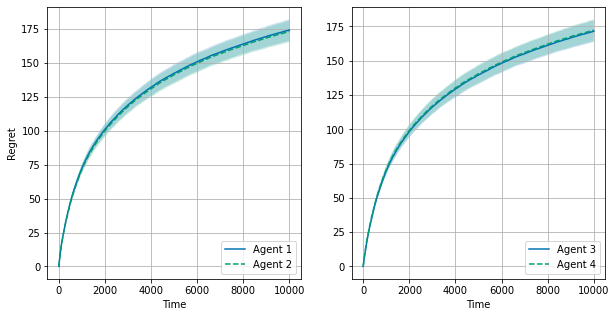

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
neighbors = [1, 2, 2, 1]
ax1.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[0], label="Agent 1")
ax1.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[0]-std_regrets_over_all_runs_dist_ucb1[0], mean_regrets_over_all_runs_dist_ucb1[0]+std_regrets_over_all_runs_dist_ucb1[0],alpha=.2)
ax1.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[1], linestyle="--", label="Agent 2")
ax1.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[1]-std_regrets_over_all_runs_dist_ucb1[1], mean_regrets_over_all_runs_dist_ucb1[1]+std_regrets_over_all_runs_dist_ucb1[1],alpha=.2)
ax2.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[2], label="Agent 3")
ax2.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[2]-std_regrets_over_all_runs_dist_ucb1[2], mean_regrets_over_all_runs_dist_ucb1[2]+std_regrets_over_all_runs_dist_ucb1[2],alpha=.2)
ax2.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[3], linestyle="--", label="Agent 4")
ax2.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[3]-std_regrets_over_all_runs_dist_ucb1[3], mean_regrets_over_all_runs_dist_ucb1[3]+std_regrets_over_all_runs_dist_ucb1[3],alpha=.2)
ax1.set_xlabel("Time")
ax1.set_ylabel("Regret")
ax1.legend(loc="lower right")
ax1.grid()
ax2.set_xlabel("Time")
ax2.legend(loc="lower right")
ax2.grid()
plt.savefig("dist_UCB1_small_graphs_N12.pdf", bbox_inches='tight')

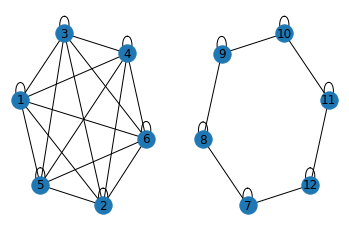

In [11]:
G1 = nx.complete_graph([1,2,3,4,5,6])
G2 = nx.cycle_graph([7,8,9,10,11,12])

nodes = list(G1.nodes)
for i in nodes:
    G1.add_edge(i,i)
nodes = list(G2.nodes)
for i in nodes:
    G2.add_edge(i,i)
plt.subplot(121)
nx.draw(G1, with_labels=True)
plt.subplot(122)
nx.draw(G2, with_labels=True)
plt.savefig("graphN12.pdf")